In [39]:
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np, random, time
from IPython import display
from matplotlib import colors

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def plot_ising_grid(init, title=''):
    '''
    creates a discrete colormap for an input Ising grid
    red for up (1) and blue for down (-1)
    '''
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    cmap = colors.ListedColormap(['blue', 'red'])
    bounds = [0,1,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(init, cmap=cmap, norm=norm)
    plt.title(title, fontsize=20)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    
    display.clear_output(wait = True)

    plt.show()

    
def ising_energy(init):
    """Computes the energy of a 2D square lattice in the Ising model"""
    
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    energy = 0
    
    for i in range(Y):
        for j in range(X):
            energy += -1 * init[i,j] * (init[(i+1) % Y ,j] + init[(i-1) % Y,j] + init[i,(j+1) % X] + init[i,(j-1) % X])
            
    energy = energy/2
    
    return energy




In [33]:
def get_clustered_spins_to_flip(flattened_grid, s, neighboring_iis, cluster_prob):
    '''
    builds up a link of points to eventually cluster and then add spins
    to cluster with probability cluster_prob
    
    the link starts from point s; for each neighbor 'n' of each point in the link 'l', if the
    spins are the same, the neighbor isn't already in the cluster, and p <= flip_prob, then
    the point is added to the link and the cluster, after which the original point 'l' is 
    removed from the link
    
    eventually, all the points in the links are exhausted and there are no more points 
    left to explore in the link. at this point, the points in the cluster are returned.
    
    adapted from the pseudocode in https://arxiv.org/pdf/cond-mat/0311623v1.pdf
    '''
    link = np.zeros_like(flattened_grid)
    link[s] = 1
    cluster_iis = np.zeros_like(flattened_grid)
    cluster_iis[s] = 1
    
    while link.sum() > 0:
        l = np.random.choice([x for x in range(len(link)) if link[x]==1])
        for n in neighboring_iis[l]:
            if (flattened_grid[n] == flattened_grid[l] and cluster_iis[n] != 1 
                and np.random.rand() <= cluster_prob):
                link[n] = 1
                cluster_iis[n] = 1
        link[l] = 0
    
    return np.where(cluster_iis==1)[0]

In [54]:
def wolff(init, L, J, T, nsteps):
    '''
    applies the wolff clustering algorithm to this ising state
    
    the grid is treated as a flattened 1D array, after which the neighboring indexes
    are found directly above, below, or next to the point in question (wrapped around)
    
    neighboring indexes format: 
     {index: [neighbor to the "left", neighbor to the "right", 
              neighbor "below", neighbor "above"]}
    '''
    N = L * L
    cluster_prob = 1-np.exp(-2*J/T)

    neighboring_iis = {i : [(i//L)*L + (i-1)%L, (i//L)*L + (i+1)%L,
                            (i+L)%N, (i-L)%N] for i in range(N)}

    grid = init[:]
    flattened_grid = grid.reshape([N])
    for i in range(nsteps):
        # choose a random spin index s in the grid
        s = np.random.randint(N) 
        cluster_iis = get_clustered_spins_to_flip(flattened_grid, s, neighboring_iis, cluster_prob)

        # after above process is done, flip the spins in the cluster
        flattened_grid[cluster_iis] *= -1

        # plot the updated wolff grid
#         plot_ising_grid(flattened_grid.reshape([L,L]))
    return grid

In [73]:
T = 2.2
J = 1
L = 5
nsteps = 10
init = np.reshape([random.choice([1, -1]) for k in range(L*L)], (L,L))
%time grid = wolff(init, L, J, T, nsteps)

CPU times: user 9.27 ms, sys: 2.82 ms, total: 12.1 ms
Wall time: 12.9 ms


In [95]:
T = 2.3
J = 1
L = 20
nsteps = 30
# init = np.reshape([random.choice([1, -1]) for k in range(L*L)], (L,L))
init = np.ones((L,L))
grid = wolff(init, L, J, T, nsteps)

In [96]:
# exploring the temperature range around the critical temp

temps = [t for t in np.arange(1.6, 2.91, .01)]
t_points = len(temps)

In [102]:
# initialize to T = 0
test = 1*np.ones((L,L))      

# rough estimate for equilibration time; 10*L many sweeps
n_eq = L #10*L

# number of sweeps to average over
n = 5*L

# factors for averaging
n1 = 1.0/(n * L**2)
n2 = 1.0/(n**2 * L**2)

In [103]:
start = time.time()

# initialize lists
eneps_list8 = np.zeros(t_points)
magps_list8 = np.zeros(t_points)
spec_heat8 = np.zeros(t_points)
mag_sus8 = np.zeros(t_points)

# these dicts correspond to temps for err purposes
e_total_dict = {}
e2_total_dict = {}
mag_total_dict = {}
mag2_total_dict = {}

grid = np.copy(test)

for i in range(t_points):
#     if i%5==0: 
    print 'T num =', i
    T = temps[i]
    
    # force the grid to equilibrate at ea. T
#     for j in range(n_eq):
    grid = wolff(grid, L, J, T, n_eq)
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total = 0
    
    # temp lists for err purposes
    e_total_temp = np.zeros(n)
    e2_total_temp = np.zeros(n)
    mag_total_temp = np.zeros(n)
    mag2_total_temp = np.zeros(n)

    # measurements to average
    for k in range(n):
        energy = ising_energy(grid)             # only taking measurements every sweep
        mag = np.sum(grid)
        
        e_total += energy
        e2_total += energy*energy
        mag_total += np.abs(mag)
        mag2_total += mag*mag
        
        e_total_temp[k] = energy
        e2_total_temp[k] = energy*energy
        mag_total_temp[k] = np.abs(mag)
        mag2_total_temp[k] = mag*mag
        
        grid = wolff(grid, L, J, T, 5)

    
    # add to lists for err purposes
    e_total_dict[i] = e_total_temp
    e2_total_dict[i] = e2_total_temp
    mag_total_dict[i] = mag_total_temp
    mag2_total_dict[i] = mag2_total_temp
    
    # compute averages
    eneps_list8[i] = n1*e_total
    magps_list8[i] = n1*mag_total
    spec_heat8[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus8[i] = (n1*mag2_total - n2*mag_total*mag_total)/T
        
        
end = time.time()
print end - start

T num = 0
T num = 1
T num = 2
T num = 3
T num = 4
T num = 5
T num = 6
T num = 7
T num = 8
T num = 9
T num = 10
T num = 11
T num = 12
T num = 13
T num = 14
T num = 15
T num = 16
T num = 17
T num = 18
T num = 19
T num = 20
T num = 21
T num = 22
T num = 23
T num = 24
T num = 25
T num = 26
T num = 27
T num = 28
T num = 29
T num = 30
T num = 31
T num = 32
T num = 33
T num = 34
T num = 35
T num = 36
T num = 37
T num = 38
T num = 39
T num = 40
T num = 41
T num = 42
T num = 43
T num = 44
T num = 45
T num = 46
T num = 47
T num = 48
T num = 49
T num = 50
T num = 51
T num = 52
T num = 53
T num = 54
T num = 55
T num = 56
T num = 57
T num = 58
T num = 59
T num = 60
T num = 61
T num = 62
T num = 63
T num = 64
T num = 65
T num = 66
T num = 67
T num = 68
T num = 69
T num = 70
T num = 71
T num = 72
T num = 73
T num = 74
T num = 75
T num = 76
T num = 77
T num = 78
T num = 79
T num = 80
T num = 81
T num = 82
T num = 83
T num = 84
T num = 85
T num = 86
T num = 87
T num = 88
T num = 89
T num = 90
T num = 9

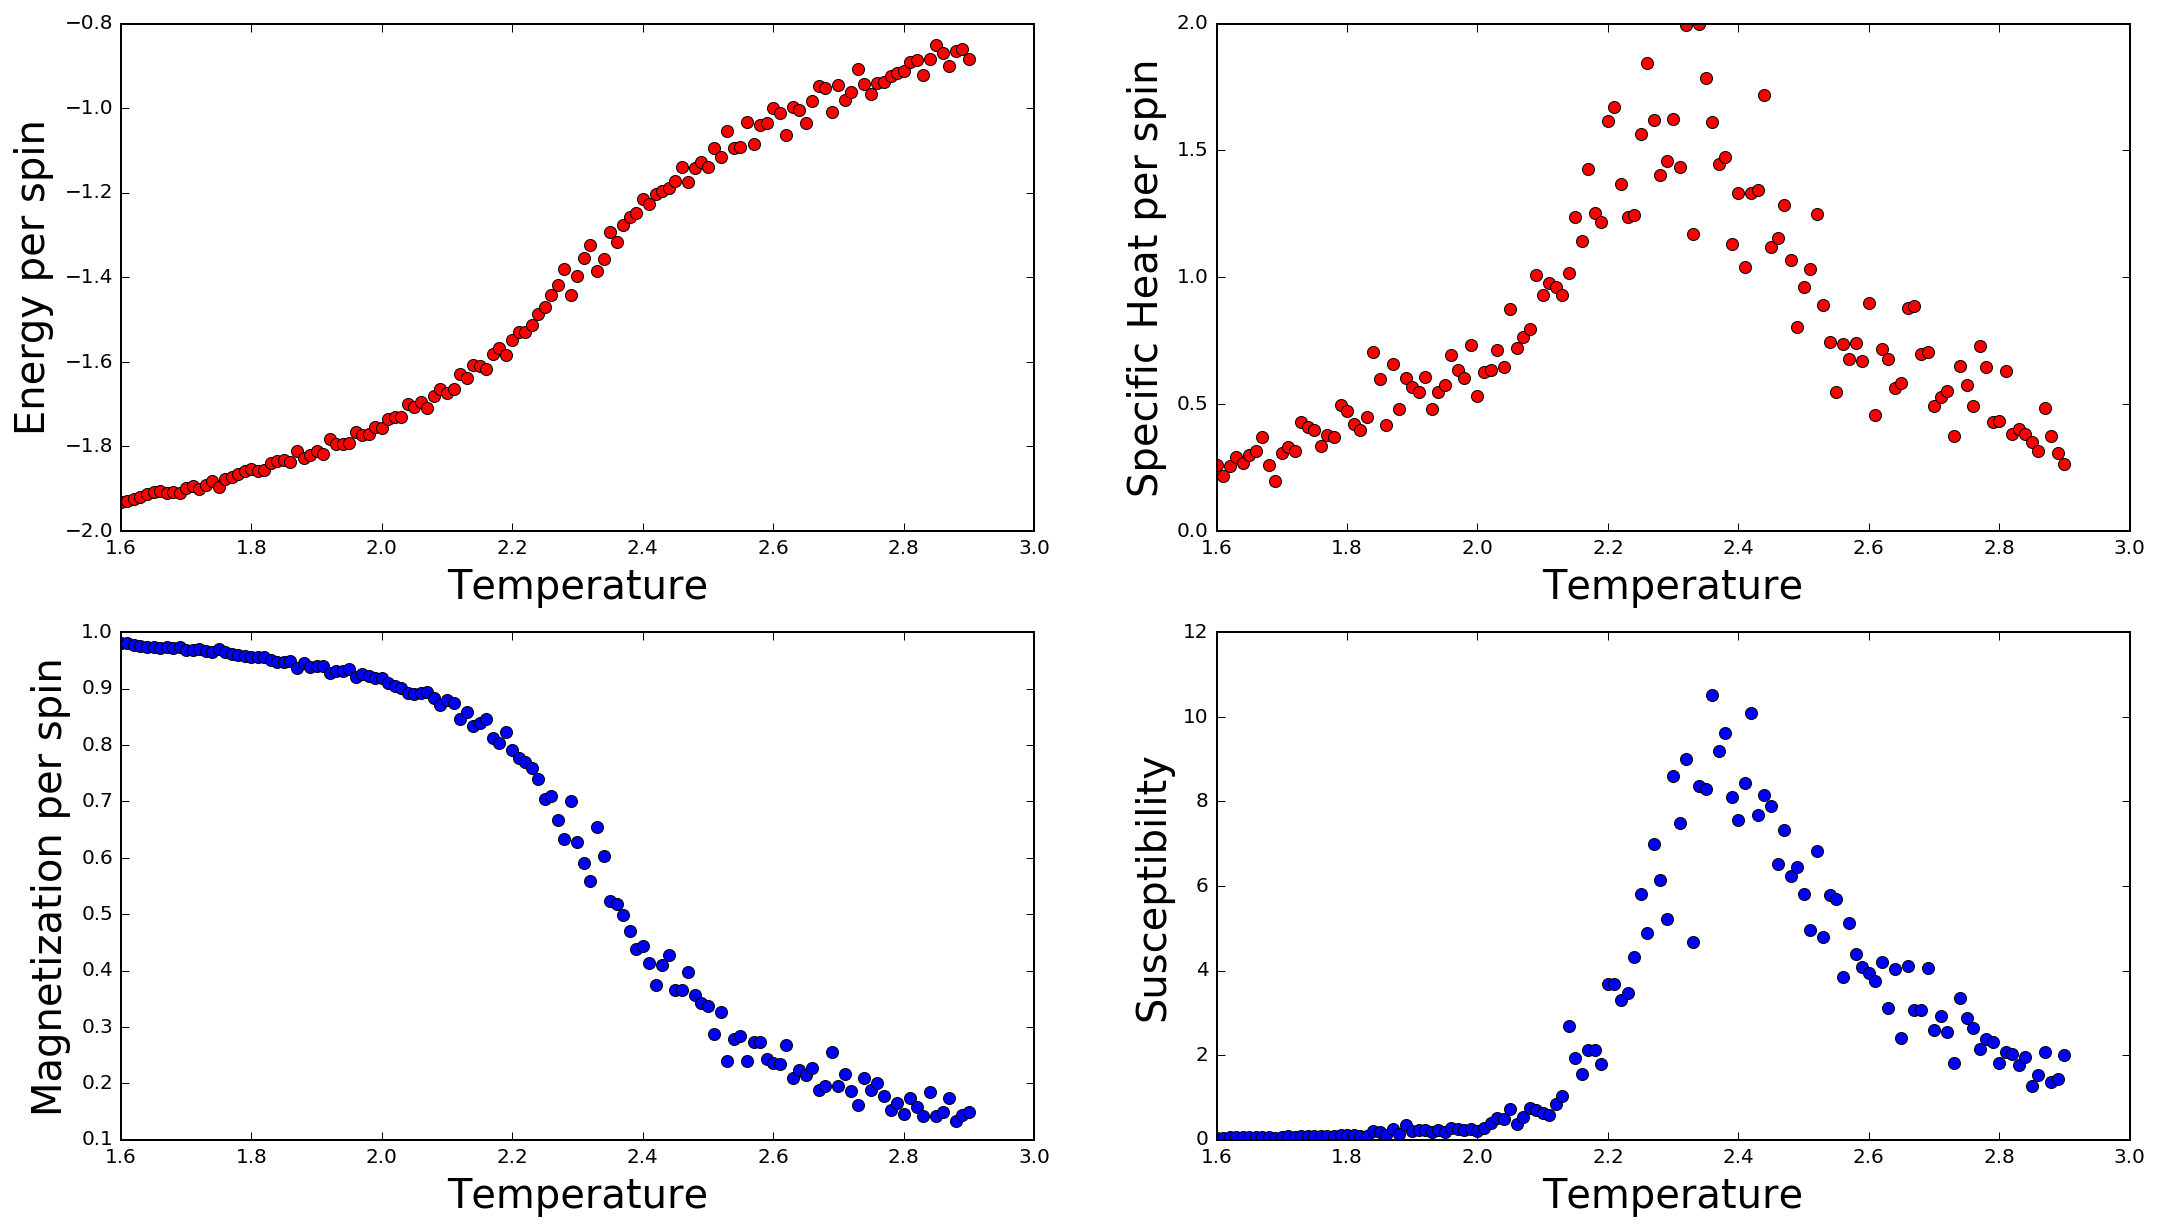

In [104]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list8, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat8, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, abs(magps_list8), 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus8, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)

plt.show()